In [2]:
function_path="/home/tarthur/software/notebook_assist/functions.R"
pkg_path="/home/tarthur/software/notebook_assist/packages.R"

wd_path="/projects/CARDIPS/analysis/epigenome_resource"
setwd(wd_path)
source(pkg_path)
source(function_path)


library(readxl)

In [3]:
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

### Aggregate TF motifs from TOBIAS output for HOCOMOCO and JASPAR

In [5]:
basedir="/projects/CARDIPS/analysis/epigenome_resource/"

aggregate_motifs = function(tissue) {
#     fs = list.files(list.files(list.files(paste0("analyses/tim/tobias/",tissue,"_atac/detect/",tissue,"_reference"),full.names=T),
#                     full.names=T,pattern="beds"),
#                     full.names=T,pattern="all")
    motif_path=paste0(basedir,"analyses/tim/gwas_tfbs/",tissue,"_motifs.bed")
#     fwrite(rbindlist(lapply(fs, function(x){ return(fread(x))})) %>% arrange(V1,V2,V3),
#               motif_path, sep="\t",row.names=F,quote=F,col.names=F)  
    return(motif_path)
}

ipsc_motif_path = aggregate_motifs("ipsc")
cvpc_motif_path = aggregate_motifs("cvpc")
ppc_motif_path  = aggregate_motifs("ppc")

In [6]:
ipsc_motifs = fread(paste0(basedir, "analyses/tim/gwas_tfbs/ipsc_motifs.bed"),sep="\t",data.table=F)
cvpc_motifs = fread(paste0(basedir, "analyses/tim/gwas_tfbs/cvpc_motifs.bed"),sep="\t",data.table=F)
ppc_motifs = fread(paste0(basedir, "analyses/tim/gwas_tfbs/ppc_motifs.bed"),sep="\t",data.table=F)

In [9]:
cols = c("MotifChrom","MotifStart","MotifEnd","MotifID","TFBSScore","MotifStrand","PeakChrom","PeakStart","PeakEnd","PeakID","FootprintScore")
colnames(ipsc_motifs) = cols
colnames(cvpc_motifs) = cols
colnames(ppc_motifs) = cols

# fwrite(ipsc_motifs, "~/projects/Resource/Figshare/iPSC_AllTFMotifs.bed.gz",sep="\t",row.names=F,quote=F, compress = "gzip")
# fwrite(cvpc_motifs, "~/projects/Resource/Figshare/CVPC_AllTFMotifs.bed.gz",sep="\t",row.names=F,quote=F, compress = "gzip")
# fwrite(ppc_motifs, "~/projects/Resource/Figshare/PPC_AllTFMotifs.bed.gz",sep="\t",row.names=F,quote=F, compress = "gzip")

### Load QTL and GWAS info

In [3]:

qtl_module_path="analyses/tim/ld_modules/modules/all_modules_091124.txt"
mainfest_path="analyses/jennifer/gwas_independent/subset_manifest.txt"
gwas_summary_path="analyses/tim/gwas_coloc2/scripts/gwas_summary.txt"

gwas_signal_path="analyses/tim/gwas_coloc/tables/Table_SX_GWAS_Signals_2024_0911.txt"

In [4]:
mods = fread(qtl_module_path,sep="\t",data.table=F)
manifest = fread(mainfest_path, data.table = F)
manifest$trait_id = NULL
names(manifest)[4] = "trait_id"


gwas_summary = fread(gwas_summary_path,sep="\t",data.table=F)
gwas_summary2 = merge(gwas_summary, manifest[,c("trait_id","description")])

coloced = gwas_summary2[ gwas_summary2$PP.H4.abf >=0.8 & gwas_summary2$topsnp_pp >= 0.01 &
             gwas_summary2$p.gwas <= 5e-8 & gwas_summary2$p.eqtl <= 5e-5, ]

In [5]:
table(indep4$Complexity)

ERROR: Error in table(indep4$Complexity): object 'indep4' not found


In [6]:
indep4 = fread(gwas_signal_path, data.table = F)
indep4$trait_gwas_index = paste(indep4$Trait_ID, indep4$GWAS_Index, sep="_")


coloced_nominated = mods %>% filter(Cluster_ID %in% indep4$Cluster_ID )

indep4_element = merge(indep4,coloced_nominated[,c("Cluster_ID","Element_ID")])

indep4_element$analysis = ifelse(grepl("^ENS",indep4_element$Element_ID), "eqtls",
                                ifelse(grepl("atac",indep4_element$Element_ID), "caqtls","haqtls"))


### Load Credible Sets in BED format

In [7]:

get_credible_sets = rbindlist(lapply(1:nrow(coloced), function(row){
    totest = coloced[row,]
    analysis = totest$analysis
    element_id = totest$element_id
    tissue = totest$tissue
    trait = totest$trait_id
    load(paste0("analyses/tim/gwas_coloc2/",analysis,"/",tissue,"/",element_id,".robj"))
    out = outlist
    traits = names(out)
    trait_idx = traits[ traits %like% trait]
#     print(unlist(trait_idx))
    res = out[[trait_idx]]$result
    cs = res[ res$in_99CredibleSet == "TRUE", c("snp","SNP.PP.H4")]
    cs$element_id = element_id
    cs$tissue = tissue
    cs$trait = trait
    cs$description = manifest$description[ manifest$trait_id == trait]
#     if (nrow(cs) <= 25) {
        cs$chrom = paste0("chr",gsub("VAR_","",str_extract(cs$snp, "VAR_[0-9]+")))
        cs$end = as.numeric(gsub("_[A-Z]+","",str_extract(cs$snp, "[0-9]+_[A-Z]+")))
        cs$start = cs$end -1 
        cs2 = cs[,c("chrom","start","end", "snp","SNP.PP.H4","element_id","tissue","trait", "description")] %>% arrange(chrom,start,end)
        cs2$nsnp = nrow(cs2)
        return(cs2)
#     }

}))


### Characterize credible sets 

In [8]:


indep4_element2 = indep4_element[,c("Trait_ID","GWAS_Index","Tissue","Cluster_ID","Element_ID")]
colnames(indep4_element2) = c("trait","gwas_index","tissue","cluster_id","element_id")



In [27]:
credset_hist2

trait,element_id,tissue,gwas_index,cluster_id,description,nsnp,tissue_description,type,Bin
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<fct>
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_100931,CVPC,16_88039793_T_C,CVPC_6681,HDL cholesterol,26,CVPC_HDL cholesterol,caQTL,26-50
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_101331,CVPC,17_598400_A_G,CVPC_522,HDL cholesterol,17,CVPC_HDL cholesterol,caQTL,16-20
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_103227,CVPC,17_16942153_T_C,CVPC_6782,HDL cholesterol,12,CVPC_HDL cholesterol,caQTL,11-15
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_109630,CVPC,17_78383251_CT_C,CVPC_7007,HDL cholesterol,33,CVPC_HDL cholesterol,caQTL,26-50
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_114234,CVPC,18_43192321_G_C,CVPC_7173,HDL cholesterol,99,CVPC_HDL cholesterol,caQTL,>50
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_11450,CVPC,1_93444330_C_A,CVPC_7182,HDL cholesterol,11,CVPC_HDL cholesterol,caQTL,11-15
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_118840,CVPC,19_7459857_G_C,CVPC_1485,HDL cholesterol,28,CVPC_HDL cholesterol,caQTL,26-50
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_122484,CVPC,19_47087297_CA_C,CVPC_7505,HDL cholesterol,37,CVPC_HDL cholesterol,caQTL,26-50
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_125793,CVPC,2_20151547_AT_A,CVPC_7659,HDL cholesterol,5,CVPC_HDL cholesterol,caQTL,1-5


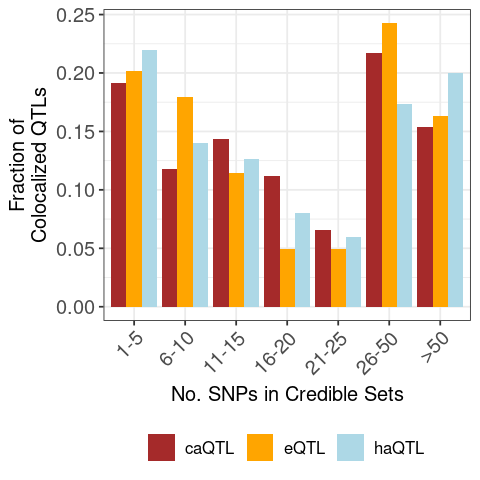

In [21]:
credset_hist = unique(get_credible_sets[, c("tissue","description","trait","element_id","nsnp")])
credset_hist2 = merge(indep4_element2, credset_hist,by=c("trait","element_id","tissue"))
credset_hist2$tissue_description = paste(credset_hist2$tissue, credset_hist2$description,sep="_")
credset_hist2$type = ifelse(grepl("^EN",credset_hist2$element_id),"eQTL",
                           ifelse(grepl("atac",credset_hist2$element_id),"caQTL","haQTL"))
credset_hist2$Bin = ifelse(credset_hist2$nsnp <= 5, "1-5",
                         ifelse(credset_hist2$nsnp <= 10, "6-10",
                               ifelse(credset_hist2$nsnp <= 15, "11-15",
                                     ifelse(credset_hist2$nsnp <= 20, "16-20",
                                           ifelse(credset_hist2$nsnp <= 25, "21-25",
                                                 ifelse(credset_hist2$nsnp <= 50, "26-50",">50"))))))
credset_hist2$Bin = factor(credset_hist2$Bin, levels = c("1-5","6-10","11-15","16-20","21-25","26-50",">50"))
credset_summary = as.data.frame(table(credset_hist2$type))

credset_hist3 = as.data.frame(table(credset_hist2$type,credset_hist2$Bin))
credset_hist3$type = as.character(credset_hist3$Var1)


credset_hist3$Fraction = ifelse(credset_hist3$type == "caQTL", credset_hist3$Freq/475,
                               ifelse(credset_hist3$type == "eQTL", credset_hist3$Freq/367,credset_hist3$Freq/150))
psize(4,4)
a = ggplot(credset_hist3, aes(Var2, Fraction, fill=type)) + theme_bw2 + 
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),axis.title = element_text(size=12),
             legend.position = "bottom" , axis.text = element_text(size=12)) + 
        xlab("No. SNPs in Credible Sets") + ylab("Fraction of\nColocalized QTLs") +
        geom_bar(stat="identity", position="dodge") + 
        scale_fill_manual(values= c("brown","orange","lightBlue")) + theme(legend.title=element_blank(),
                                                      legend.text=element_text(size=10))
a


caQTL  eQTL haQTL 
  530   404   180 

[1] 1114

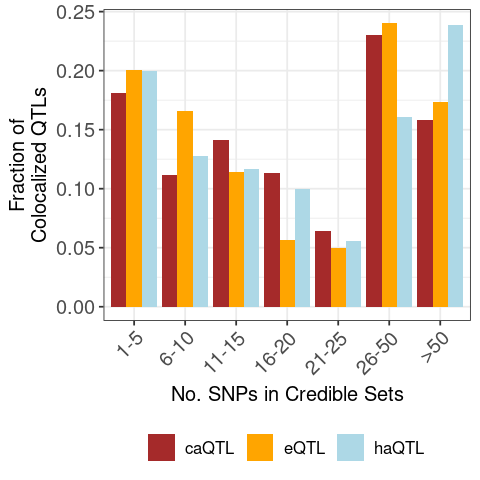

In [30]:
### checking 

credset_hist = unique(get_credible_sets[, c("tissue","description","trait","element_id","nsnp")])
# credset_hist2 = merge(indep4_element2, credset_hist,by=c("trait","element_id","tissue"))
credset_hist$tissue_description = paste(credset_hist$tissue, credset_hist$description,sep="_")
credset_hist$type = ifelse(grepl("^EN",credset_hist$element_id),"eQTL",
                           ifelse(grepl("atac",credset_hist$element_id),"caQTL","haQTL"))
credset_hist$Bin = ifelse(credset_hist$nsnp <= 5, "1-5",
                         ifelse(credset_hist$nsnp <= 10, "6-10",
                               ifelse(credset_hist$nsnp <= 15, "11-15",
                                     ifelse(credset_hist$nsnp <= 20, "16-20",
                                           ifelse(credset_hist$nsnp <= 25, "21-25",
                                                 ifelse(credset_hist$nsnp <= 50, "26-50",">50"))))))
credset_hist$Bin = factor(credset_hist$Bin, levels = c("1-5","6-10","11-15","16-20","21-25","26-50",">50"))
credset_summary = as.data.frame(table(credset_hist$type))

credset_hist3 = as.data.frame(table(credset_hist$type,credset_hist$Bin))
credset_hist3$type = as.character(credset_hist3$Var1)


credset_hist3$Fraction = ifelse(credset_hist3$type == "caQTL", credset_hist3$Freq/530,
                               ifelse(credset_hist3$type == "eQTL", credset_hist3$Freq/404,credset_hist3$Freq/180))
psize(4,4)
a = ggplot(credset_hist3, aes(Var2, Fraction, fill=type)) + theme_bw2 + 
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),axis.title = element_text(size=12),
             legend.position = "bottom" , axis.text = element_text(size=12)) + 
        xlab("No. SNPs in Credible Sets") + ylab("Fraction of\nColocalized QTLs") +
        geom_bar(stat="identity", position="dodge") + 
        scale_fill_manual(values= c("brown","orange","lightBlue")) + theme(legend.title=element_blank(),
                                                      legend.text=element_text(size=10))
a
table(credset_hist$type)
nrow(credset_hist)

In [10]:
nrow(get_credible_sets)

get_credible_sets$tissue_element = paste(get_credible_sets$tissue, get_credible_sets$element_id, sep="_")
get_credible_sets2 = merge(get_credible_sets,mods[,c("tissue_element","Cluster_ID")],by="tissue_element")
nrow(get_credible_sets)
nrow(get_credible_sets2)
get_credible_sets2$coloc_id = paste(get_credible_sets2$Cluster_ID,get_credible_sets2$trait,sep="_")
topsnps = get_credible_sets2 %>% group_by(coloc_id) %>% filter(SNP.PP.H4 == max(SNP.PP.H4)) %>% ungroup()
topsnps$coloc_snp_id = paste(topsnps$coloc_id,topsnps$snp,sep="_")




[1] 32343

[1] 32343

[1] 32343

In [1]:
cvpc274 = get_credible_sets2[ get_credible_sets2$Cluster_ID == "CVPC_274",]
# cvpc274 %>% arrange(-SNP.PP.H4)

ERROR: Error in eval(expr, envir, enclos): object 'get_credible_sets2' not found


In [31]:
ppc122 = get_credible_sets2[ get_credible_sets2$Cluster_ID == "PPC_122",]
ppc122 %>% filter(snp == "VAR_7_28149792_T_C") %>% arrange(-SNP.PP.H4)

tissue_element,chrom,start,end,snp,SNP.PP.H4,element_id,tissue,trait,description,nsnp,Cluster_ID,coloc_id
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
PPC_ppc_atac_peak_244298,chr7,28149791,28149792,VAR_7_28149792_T_C,0.01415807,ppc_atac_peak_244298,PPC,Mahajan.NatGenet2018b.T2D.European_sorted,type 2 diabetes,8,PPC_122,PPC_122_Mahajan.NatGenet2018b.T2D.European_sorted
PPC_ENSG00000153814.13,chr7,28149791,28149792,VAR_7_28149792_T_C,0.01346689,ENSG00000153814.13,PPC,Mahajan.NatGenet2018b.T2D.European_sorted,type 2 diabetes,5,PPC_122,PPC_122_Mahajan.NatGenet2018b.T2D.European_sorted


In [19]:
fwrite(credset_hist3,"~/projects/Resource/iPSCORE_Multi-QTL_Resource/SourceData/SOURCEDATA.FIGURE6A.txt",sep="\t",row.names=F,quote=F)

In [9]:
table(credset_hist2$type)
nrow(credset_hist2)


caQTL  eQTL haQTL 
  475   367   150 

[1] 992

In [11]:
credset_hist2$coloc_id = paste(credset_hist2$tissue, credset_hist2$element_id, credset_hist2$trait,sep="_")

In [12]:
get_credible_sets$coloc_id = paste(get_credible_sets$tissue, get_credible_sets$element_id, get_credible_sets$trait,sep="_")
cs_filt = get_credible_sets[ get_credible_sets$coloc_id %in% credset_hist2$coloc_id,]


cs_filt$tissue_element = paste(cs_filt$tissue, cs_filt$element_id, sep="_")
highcon_cs = as.data.frame(cs_filt[ cs_filt$nsnp <= 25, ])
indep4_element3 = merge(indep4_element2, credset_hist,by=c("trait","element_id","tissue"))
indep4_element3$tissue_element = paste(indep4_element3$tissue, indep4_element3$element_id, sep="_")
highcon_cs2 = unique(merge(highcon_cs,indep4_element3[,c("tissue_element","cluster_id")]))


highcon_cs2$tissue_element = NULL

In [15]:
credset_hist2

trait,element_id,tissue,gwas_index,cluster_id,description,nsnp,tissue_description,type,Bin,coloc_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<fct>,<chr>
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_100931,CVPC,16_88039793_T_C,CVPC_6681,HDL cholesterol,26,CVPC_HDL cholesterol,caQTL,26-50,CVPC_cvpc_atac_peak_100931_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_101331,CVPC,17_598400_A_G,CVPC_522,HDL cholesterol,17,CVPC_HDL cholesterol,caQTL,16-20,CVPC_cvpc_atac_peak_101331_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_103227,CVPC,17_16942153_T_C,CVPC_6782,HDL cholesterol,12,CVPC_HDL cholesterol,caQTL,11-15,CVPC_cvpc_atac_peak_103227_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_109630,CVPC,17_78383251_CT_C,CVPC_7007,HDL cholesterol,33,CVPC_HDL cholesterol,caQTL,26-50,CVPC_cvpc_atac_peak_109630_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_114234,CVPC,18_43192321_G_C,CVPC_7173,HDL cholesterol,99,CVPC_HDL cholesterol,caQTL,>50,CVPC_cvpc_atac_peak_114234_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_11450,CVPC,1_93444330_C_A,CVPC_7182,HDL cholesterol,11,CVPC_HDL cholesterol,caQTL,11-15,CVPC_cvpc_atac_peak_11450_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_118840,CVPC,19_7459857_G_C,CVPC_1485,HDL cholesterol,28,CVPC_HDL cholesterol,caQTL,26-50,CVPC_cvpc_atac_peak_118840_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_122484,CVPC,19_47087297_CA_C,CVPC_7505,HDL cholesterol,37,CVPC_HDL cholesterol,caQTL,26-50,CVPC_cvpc_atac_peak_122484_biomarkers-30760-both_sexes-irnt.meta
biomarkers-30760-both_sexes-irnt.meta,cvpc_atac_peak_125793,CVPC,2_20151547_AT_A,CVPC_7659,HDL cholesterol,5,CVPC_HDL cholesterol,caQTL,1-5,CVPC_cvpc_atac_peak_125793_biomarkers-30760-both_sexes-irnt.meta


In [50]:
highcon_cs_rsids = rbindlist(lapply(unique(highcon_cs$tissue_element), function(te){
    tiss_ele = highcon_cs[ highcon_cs$tissue_element == te,]
    type = ifelse(grepl("atac",tiss_ele$tissue_element), "caqtls", ifelse(grepl("chip",tiss_ele$tissue_element), "haqtls","eqtls"))
    path = unique(paste0(type,"/",unique(tiss_ele$tissue),"/step_1/genotype/by_element/gt_info.",unique(tiss_ele$element_id),".txt"))
    return(fread(path,sep="\t",data.table=F) %>% select(id, rsid))
}))


In [57]:
highcon_cs_rsids2 = unique(highcon_cs_rsids)
colnames(highcon_cs_rsids2) = c("snp","rsid")

df = merge(highcon_cs2,highcon_cs_rsids2)
length(unique(df$rsid))

[1] 3601

In [38]:
fwrite(highcon_cs, "analyses/tim/gwas_tfbs/highcon_crediblesets.txt",sep="\t",row.names=F,quote=F)

In [12]:
message(paste("There are",nrow(highcon_cs2),"SNPs in", length(unique(highcon_cs$coloc_id)),"high confidence credible sets"))

There are 6164 SNPs in 611 high confidence credible sets







### Intersect TF Motif Bed with Credible Set

In [76]:
ipsc_cs_path =  paste0(basedir,"analyses/tim/gwas_tfbs/ipsc_cs.bed")
cvpc_cs_path =  paste0(basedir,"analyses/tim/gwas_tfbs/cvpc_cs.bed")
ppc_cs_path  =  paste0(basedir,"analyses/tim/gwas_tfbs/ppc_cs.bed")

# fwrite(highcon_cs2 %>% filter(tissue == "iPSC" ) %>% arrange(chrom,start,end),
#        ipsc_cs_path, sep="\t",row.names=F,col.names=F,quote=F)

# fwrite(highcon_cs2 %>% filter(tissue == "CVPC" ) %>% arrange(chrom,start,end),
#        cvpc_cs_path, sep="\t",row.names=F,col.names=F,quote=F)

# fwrite(highcon_cs2 %>% filter(tissue == "PPC" ) %>% arrange(chrom,start,end),
#        ppc_cs_path, sep="\t",row.names=F,col.names=F,quote=F)

In [77]:
bedtools = "/frazer01/software/bedtools-2.25.0/bin/bedtools"
intersect_motifs = function(motif_path, snp_path){
    cmd = paste(bedtools, "intersect -a",motif_path , "-b", snp_path, "-wb")
    return(fread(cmd = cmd))
}

ipsc_overlap = intersect_motifs(ipsc_motif_path,ipsc_cs_path)
cvpc_overlap = intersect_motifs(cvpc_motif_path,cvpc_cs_path)
ppc_overlap = intersect_motifs(ppc_motif_path,ppc_cs_path)

In [88]:
ppc_motifs = fread(ppc_motif_path,sep="\t",data.table=F)
head(ppc_motifs)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
1,chr1,820107,820119,ZSCAN29_MA1602.1,9.71302,+,chr1,820105,820650,ppc_atac_peak_2,0.03778
2,chr1,820111,820126,EHF_MA0598.3,7.15043,+,chr1,820105,820650,ppc_atac_peak_2,0.03778
3,chr1,820116,820128,GRHL2_HUMAN.H11MO.0.A_GRHL2_HUMAN.H11MO.0.A,7.67740,+,chr1,820105,820650,ppc_atac_peak_2,0.03778
4,chr1,820116,820131,NFAC1_HUMAN.H11MO.0.B_NFAC1_HUMAN.H11MO.0.B,7.55020,-,chr1,820105,820650,ppc_atac_peak_2,0.03778
5,chr1,820119,820138,MAF_HUMAN.H11MO.0.A_MAF_HUMAN.H11MO.0.A,8.39424,-,chr1,820105,820650,ppc_atac_peak_2,0.03778
6,chr1,820121,820130,NFAC2_HUMAN.H11MO.0.B_NFAC2_HUMAN.H11MO.0.B,7.85007,-,chr1,820105,820650,ppc_atac_peak_2,0.03778


[1] 296

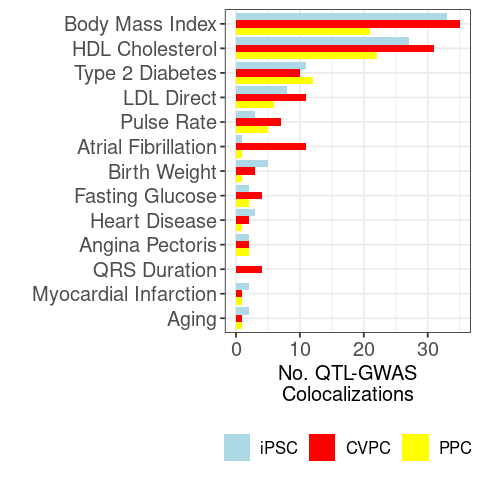

In [248]:
ppc_uni = unique(ppc_overlap[ ,c("V20","V18","V23")])
ipsc_uni = unique(ipsc_overlap[ ,c("V20","V18","V23")])
cvpc_uni = unique(cvpc_overlap[ ,c("V20","V18","V23")])

cs_all = rbindlist(list(ipsc_uni[,1:2],cvpc_uni[,1:2],ppc_uni[,1:2]))
nrow(cs_all)
cs_all2 = as.data.frame(table(cs_all$V20, cs_all$V18))
cs_all2$Trait = ifelse(cs_all2$Var1 == "birth weight (eur)", "Birth Weight",
                      ifelse(cs_all2$Var1 == "fasting glucose", "Fasting Glucose",
                            ifelse(cs_all2$Var1 == "Multivariate Longevity", "Aging",
                                  ifelse(cs_all2$Var1 == "type 2 diabetes", "Type 2 Diabetes",as.character(cs_all2$Var1)))))

cs_all2$Trait = gsub("I[0-9]+ ","",cs_all2$Trait)
cs_all2$Trait = gsub(" \\(BMI\\)","",cs_all2$Trait)
cs_all2$Trait = gsub(" and flutter","",cs_all2$Trait)
cs_all2$Trait = gsub("Chronic ","",cs_all2$Trait)
cs_all2$Trait = gsub("Acute ","",cs_all2$Trait)
cs_all2$Trait = gsub("ischaemic ","",cs_all2$Trait)

cs_all2$Trait = str_to_title(cs_all2$Trait)
cs_all2$Trait = gsub("Ldl","LDL",cs_all2$Trait)
cs_all2$Trait = gsub("Hdl","HDL",cs_all2$Trait)
cs_all2$Trait = gsub("Qrs","QRS",cs_all2$Trait)


cs_all2$Tissue = factor(cs_all2$Var2, levels = rev(c("iPSC","CVPC","PPC")))

b = ggplot(cs_all2, aes( Freq, reorder(Trait,Freq),fill =Tissue)) + theme_bw2 + 
        theme(axis.text = element_text(size=12),axis.title = element_text(size=12),
             legend.position = "bottom") +
        xlab("No. QTL-GWAS\nColocalizations") + ylab("") +
        geom_bar(stat="identity", position = "dodge") +
        scale_fill_manual(values = rev(c("lightBlue","red","yellow"))) +
        guides(fill = guide_legend(reverse=T)) + theme(legend.title=element_blank(),
                                                      legend.text=element_text(size=10))

psize(4,4)
# png("~/projects/Resource/notebooks/toGitHub/figures/figure6_cs.png",units="in",res=300,height=7,width=4)
# png("~/defense/gwas_tf_snps.png",units="in",res=300,height=4,width=4)
plot_grid(b)
# dev.off()

# plot_grid(a,b, nrow=2, rel_heights = c(0.8,1))
# dev.off()

In [18]:
fwrite(cs_all2[,c(4,5,3)], "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE6B.txt",sep="\t",row.names=F,quote=F)

In [32]:

ipsc_overlap$tissue_element = paste(ipsc_overlap$V18,ipsc_overlap$V17, sep="_")
cvpc_overlap$tissue_element = paste(cvpc_overlap$V18,cvpc_overlap$V17, sep="_")
ppc_overlap$tissue_element = paste(ppc_overlap$V18,ppc_overlap$V17, sep="_")

In [344]:
ipsc_overlap2 = ipsc_overlap[,c("V10","V4","V15","V19","V20","V18","V23","V17")]
cvpc_overlap2 = cvpc_overlap[,c("V10","V4","V15","V19","V20","V18","V23","V17")]
ppc_overlap2 = ppc_overlap[,c("V10","V4","V15","V19","V20","V18","V23","V17")]

all_overlap = unique(rbind(rbind(ipsc_overlap2,cvpc_overlap2),ppc_overlap2))
colnames(all_overlap) = c("TFBS_peak","TF_Motif","SNP","Trait_ID","Trait_Description","Tissue","Cluster_ID","qElement")

mods_tmp = mods[ ,c("Cluster_ID","Element_ID")]
colnames(mods_tmp) = c("TFBS_Cluster_ID","TFBS_peak")



all_overlap2 = merge(mods_tmp,all_overlap,all=T)

all_overlap3 = all_overlap2[ !is.na(all_overlap2$TF_Motif),]
all_overlap3$In_Any_caQTL = ifelse(all_overlap3$TFBS_peak %in% mods$Element_ID, "TRUE","FALSE")
table(all_overlap3$In_Any_caQTL)
all_overlap3$TFBS_Cluster_ID[ is.na(all_overlap3$TFBS_Cluster_ID)] = "Not a caPeak"
all_overlap3$Same_QTL = ifelse(is.na(all_overlap3$TFBS_Cluster_ID), "FALSE",
                               ifelse(all_overlap3$TFBS_Cluster_ID == all_overlap3$Cluster_ID, "TRUE","FALSE"))
all_overlap3$Same_caPeak = ifelse(all_overlap3$TFBS_peak == all_overlap3$qElement, "TRUE","FALSE")


FALSE  TRUE 
 2273  1778 

In [335]:
message(paste("There are ", nrow(all_overlap3), "TF motif overlaps by credible set SNPs"))
message(paste("There are ", length(unique(all_overlap3$SNP)), "unique credible set SNPs that overlap a TF motif"))

message(paste("There are ", nrow(unique(all_overlap3[,c("SNP","Trait_Description","Cluster_ID")])),
              "QTL - GWAS colocalizations with at least one credible SNP that overlaps a TF motif"))

# unique(all_overlap3[,c("SNP","Trait_Description","Cluster_ID")])


length(unique(all_overlap3$SNP))
# unique(all_overlap3[,c("SNP","Trait_Description","Cluster_ID")])

There are  4051 TF motif overlaps by credible set SNPs

There are  356 unique credible set SNPs that overlap a TF motif

There are  548 QTL - GWAS colocalizations with at least one credible SNP that overlaps a TF motif



[1] 356

In [409]:
tfs_summ = unique(all_overlap3[,c("SNP","TFBS_peak","Tissue","TF_Motif")])
nrow(tfs_summ)
tfs_summ$TF_name = gsub("_MA.*","",tfs_summ$TF_Motif)
tfs_summ$TF_name = gsub("_.*","",gsub("_HUMAN.H11MO","",tfs_summ$TF_name))


[1] 2747

In [458]:
# mods[,c("Cluster_ID","Complexity","qtl_combo")]

In [494]:
tfs_summ$tissue_variant = paste(tfs_summ$Tissue, tfs_summ$SNP, sep="_")
tfs_summ2 = rbindlist(lapply(unique(tfs_summ$tissue_variant), function(x){
    tmp = tfs_summ[ tfs_summ$tissue_variant == x,]
    out = data.frame(Tissue =  unique(tmp$Tissue),
                     TFBS_peak = unique(tmp$TFBS_peak),
                     SNP = unique(tmp$SNP))
    out$No_Motifs = length(tmp$TF_name)
    out$motifs = paste(sort(tmp$TF_name),collapse = ",")
    return(out)
}))
all_overlap5 = merge(all_overlap4,tfs_summ2,by=c("Tissue","TFBS_peak","SNP"))
all_overlap5$coloc_snp_id = NULL

pp_snp = get_credible_sets2 %>% group_by(Cluster_ID,description,snp) %>% top_n(1,SNP.PP.H4) %>% 
                select(Cluster_ID,description,snp,SNP.PP.H4) %>% ungroup()
colnames(pp_snp) = c("Cluster_ID","Trait_Description","SNP","SNP.PP")
all_overlap5a =merge(all_overlap5,pp_snp,by=c("Cluster_ID","Trait_Description","SNP"))

all_overlap6 = all_overlap5a [,c("Tissue","Cluster_ID","Trait_Description","SNP","SNP.PP",
                                "TFBS_peak","No_Motifs","In_Any_caQTL","Same_QTL","TopSNP","motifs")]

names(all_overlap6)[4] = "SNP_ID"
names(all_overlap6)[5] = "SNP_PP"
names(all_overlap6)[6] = "TFBS_Peak_ID"
names(all_overlap6)[7] = "No_Overlapped_Motifs"
names(all_overlap6)[8] = "TFBS_Peak_Is_caPeak"
names(all_overlap6)[9] = "TFBS_Peak_In_Same_QTL"

names(all_overlap6)[10] = "SNP_Is_TopSNP"
names(all_overlap6)[11] = "Overlapped_Motif_IDs"



all_overlap6$TFBS_Peak_In_Same_QTL = ifelse(all_overlap6$TFBS_Peak_In_Same_QTL == "TRUE",1,0)
all_overlap7 = all_overlap6 %>% arrange(-TFBS_Peak_In_Same_QTL,-No_Overlapped_Motifs)
all_overlap7$TFBS_Peak_In_Same_QTL = ifelse(all_overlap7$TFBS_Peak_In_Same_QTL == 1,"TRUE","FALSE")
unique(all_overlap7$Trait_Description)

[1] "HDL cholesterol"                     "type 2 diabetes"                    
 [3] "I48 Atrial fibrillation and flutter" "LDL direct"                         
 [5] "Body mass index (BMI)"               "Pulse rate"                         
 [7] "birth weight (eur)"                  "fasting glucose"                    
 [9] "I20 Angina pectoris"                 "I25 Chronic ischaemic heart disease"
[11] "QRS duration"                        "I21 Acute myocardial infarction"    
[13] "Multivariate Longevity"

In [495]:
all_overlap7$Trait_Description = ifelse(all_overlap7$Trait_Description == "birth weight (eur)", "Birth Weight",
                      ifelse(all_overlap7$Trait_Description == "fasting glucose", "Fasting Glucose",
                            ifelse(all_overlap7$Trait_Description == "Multivariate Longevity", "Aging",
                                  ifelse(all_overlap7$Trait_Description == "type 2 diabetes", "Type 2 Diabetes",
                                         as.character(all_overlap7$Trait_Description)))))

all_overlap7$Trait_Description = gsub("I[0-9]+ ","",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub(" \\(BMI\\)","",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub(" and flutter","",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub("Chronic ","",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub("Acute ","",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub("ischaemic ","",all_overlap7$Trait_Description)

all_overlap7$Trait_Description = str_to_title(all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub("Ldl","LDL",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub("Hdl","HDL",all_overlap7$Trait_Description)
all_overlap7$Trait_Description = gsub("Qrs","QRS",all_overlap7$Trait_Description)
unique(all_overlap7$Trait_Description)

[1] "HDL Cholesterol"       "Type 2 Diabetes"       "Atrial Fibrillation"  
 [4] "LDL Direct"            "Body Mass Index"       "Pulse Rate"           
 [7] "Birth Weight"          "Fasting Glucose"       "Angina Pectoris"      
[10] "Heart Disease"         "QRS Duration"          "Myocardial Infarction"
[13] "Aging"

In [498]:
all_overlap8 = merge(all_overlap7,unique(mods[,c("Cluster_ID","Complexity","qtl_combo")]))
all_overlap8$Priority_Rank = ifelse(all_overlap8$TFBS_Peak_Is_caPeak == "TRUE" & all_overlap8$TFBS_Peak_In_Same_QTL == "TRUE", "High",
                                   ifelse(all_overlap8$TFBS_Peak_Is_caPeak == "TRUE" & 
                                          all_overlap8$TFBS_Peak_In_Same_QTL == "FALSE","Moderate","Low"))
table(all_overlap8$Priority_Rank)


    High      Low Moderate 
     167      344       37 

In [508]:
all_overlap9 = all_overlap8[,c("Tissue","Cluster_ID","Complexity","qtl_combo","Trait_Description","SNP_ID",
                   "SNP_PP","TFBS_Peak_ID","Priority_Rank","No_Overlapped_Motifs","Overlapped_Motif_IDs")] 
all_overlap9$Priority_Rank = factor(all_overlap9$Priority_Rank, levels = c("High","Moderate","Low"))
names(all_overlap9)[4] = "QTL_Combo"


In [68]:
all_overlap9[ all_overlap9$Priority_Rank == "High" & all_overlap9$Trait_Description == "QRS Duration" & 
                 all_overlap9$Tissue == "CVPC",]

Tissue,Cluster_ID,Complexity,QTL_Combo,Trait_Description,SNP_ID,SNP_PP,TFBS_Peak_ID,Priority_Rank,No_Overlapped_Motifs,Overlapped_Motif_IDs
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
CVPC,CVPC_274,Complex,caQTL-haQTL,QRS Duration,VAR_13_73944073_G_A,0.2583801,cvpc_atac_peak_73241,High,10,"ARI5B.0.C,MEF2A,MEF2C,STA5A.0.A,STA5B.0.A,Stat5a,Stat5aStat5b,Stat5b,ZFP28.0.C,ZN467.0.C"


In [528]:
c_data = as.data.frame(table(all_overlap9$Priority_Rank))
colnames(c_data) = c("Priority_Rank","No_MOPCVs") 

fwrite(c_data,"~/projects/Resource/iPSCORE_Multi-QTL_Resource/SourceData/SOURCEDATA.FIGURE6C.txt",
       sep="\t",row.names=F,quote=F)

In [510]:
write_xlsx(all_overlap9 %>% arrange(Priority_Rank, -No_Overlapped_Motifs),"~/projects/Resource/RevisionTables/TABLE.GWAS_SNPs.xlsx")

In [4]:
all_overlap9 = read_xlsx("~/projects/Resource/RevisionTables/TABLE.GWAS_SNPs.xlsx")